<a href="https://colab.research.google.com/github/hyeonsang010716/Machine_Learning/blob/main/mercari_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd
mercari_df = pd.read_csv('train.tsv', sep='\t')
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [4]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268020 entries, 0 to 268019
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           268020 non-null  int64  
 1   name               268020 non-null  object 
 2   item_condition_id  268020 non-null  int64  
 3   category_name      266858 non-null  object 
 4   brand_name         153457 non-null  object 
 5   price              268020 non-null  float64
 6   shipping           268020 non-null  int64  
 7   item_description   268020 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 16.4+ MB


타겟값의 분포도

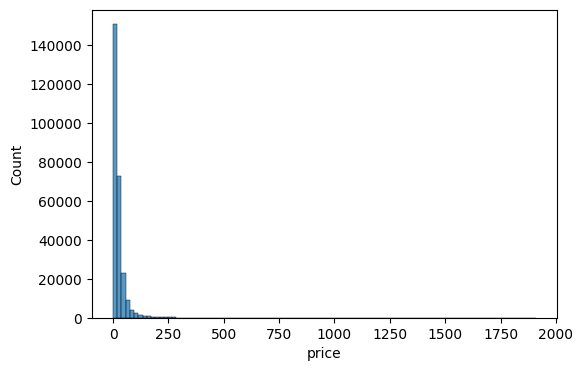

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins = 100)
plt.show()

분포 변화

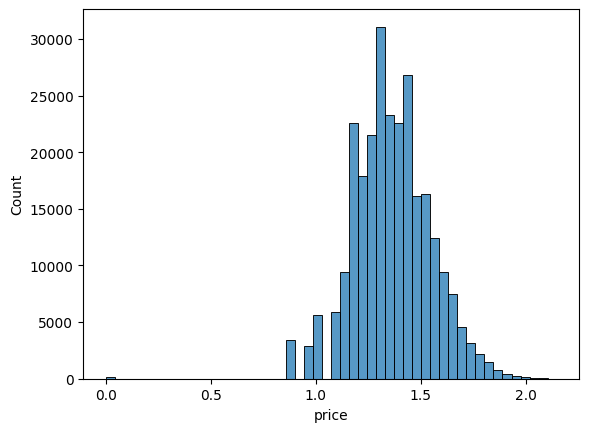

In [7]:
import numpy as np
y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins = 50)
plt.show()

In [9]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

각 피처들 유형

In [11]:
print("Shipping 값")
print(mercari_df['shipping'].value_counts())

Shipping 값
shipping
0    148253
1    119767
Name: count, dtype: int64


In [12]:
print("item_condition_id 값")
print(mercari_df['item_condition_id'].value_counts())

item_condition_id 값
item_condition_id
1    115600
3     78061
2     68191
4      5705
5       463
Name: count, dtype: int64


상세 설명이 없는 값

In [13]:
print(len(mercari_df[mercari_df['item_description'] == 'No description yet']))

15022


category가 대/중/소 로 되어있기 때문에 컬럼 재설정

In [16]:
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [19]:
mercari_df[['cat_dae','cat_jung','cat_so']].head(5)

,cat_dae,cat_jung,cat_so
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


그 외 각 피처들 Null 값 처리

In [20]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [21]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268020 entries, 0 to 268019
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           268020 non-null  int64  
 1   name               268020 non-null  object 
 2   item_condition_id  268020 non-null  int64  
 3   category_name      268020 non-null  object 
 4   brand_name         268020 non-null  object 
 5   price              268020 non-null  float64
 6   shipping           268020 non-null  int64  
 7   item_description   268020 non-null  object 
 8   cat_dae            268020 non-null  object 
 9   cat_jung           268020 non-null  object 
 10  cat_so             268020 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 22.5+ MB


종류

In [23]:
print(mercari_df['brand_name'].nunique())
print(mercari_df['name'].nunique())
print(mercari_df['item_description'].str.len().mean())

2933
243245
145.46777106186104


In [24]:
import gc
gc.collect()

216

name -> Count로 벡터화 , item_description -> TF-IDF로 벡터화

In [25]:
cnt_vec = CountVectorizer()
tfidf_vec = TfidfVectorizer(max_features=50000 , ngram_range = (1,3) , stop_words='english')

X_name = cnt_vec.fit_transform(mercari_df.name)
X_item_desc = tfidf_vec.fit_transform(mercari_df.item_description)

In [26]:
print(X_name.shape)
print(X_item_desc.shape)

(268020, 42172)
(268020, 50000)


In [27]:
from sklearn.preprocessing import LabelBinarizer
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_condition_id = LabelBinarizer(sparse_output=True)
X_item_condition_id = lb_item_condition_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [28]:
print(X_brand.shape)
print(X_item_condition_id.shape)
print(X_shipping.shape)
print(X_cat_dae.shape)
print(X_cat_jung.shape)
print(X_cat_so.shape)

(268020, 2933)
(268020, 5)
(268020, 1)
(268020, 11)
(268020, 114)
(268020, 775)


희소행렬 결합

In [29]:
from scipy.sparse import hstack
sparse_matrix_list = (X_name , X_item_desc , X_brand , X_item_condition_id , X_shipping , X_cat_dae , X_cat_jung , X_cat_so)
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(X_features_sparse.shape)

(268020, 96011)


릿지 모델 + 평가

In [30]:
def rmsle(y , y_pred):
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):
  #원본 데이터를 log 씌었으니까 다시 복원
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)
  rmsle_result = rmsle(y_test_exmpm , preds_exmpm)
  return rmsle_result

In [31]:
def model_train_predict(model , matrix_list):
  X = hstack(matrix_list).tocsr()
  X_train , X_test , y_train , y_test = train_test_split(X , mercari_df['price'] , test_size = 0.2 , random_state = 156)
  model.fit(X_train , y_train)
  preds = model.predict(X_test)
  return evaluate_org_price(y_test , preds)

In [32]:
sparse_matrix_list1 = (X_name , X_brand , X_item_condition_id , X_shipping , X_cat_dae , X_cat_jung , X_cat_so) #설명X
sparse_matrix_list2 = (X_name , X_item_desc , X_brand , X_item_condition_id , X_shipping , X_cat_dae , X_cat_jung , X_cat_so) #설명O

linear_model = Ridge(solver = 'lsqr' , fit_intercept = False)

print("설명을 제외한 rmsle :" , model_train_predict(linear_model , sparse_matrix_list1))
print("설명을 포함한 rmsle :" , model_train_predict(linear_model , sparse_matrix_list2))

설명을 제외한 rmsle : 0.5175801213497655
설명을 포함한 rmsle : 0.4970047602030283


LightGBM 회귀 모델 과 앙상블 이용한 최종  평가


In [37]:
from lightgbm import LGBMRegressor
sparse_matrix_list = (X_name , X_item_desc , X_brand , X_item_condition_id , X_shipping , X_cat_dae , X_cat_jung , X_cat_so)
lightgbm = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
print("rmsle :", model_train_predict(lightgbm , sparse_matrix_list))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 196.952619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960892
[LightGBM] [Info] Number of data points in the train set: 214416, number of used features: 40058
[LightGBM] [Info] Start training from score 2.980156
rmsle : 0.5048154265186298
